In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
pd.set_option('display.max_columns', None)  

# the service URL
livechart = "https://nds.iaea.org/relnsd/v1/data?"

# There have been cases in which the service returns an HTTP Error 403: Forbidden
def lc_pd_dataframe(url):
    req = urllib.request.Request(url)
    req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
    return pd.read_csv(urllib.request.urlopen(req))

In [3]:
# Function to plot the enrgy levels
# Parameters: df   : dataframe with the database from IAEA 
#             A    : mass number
#             cut  : cutoff energy for the plot 
#             delta: separation of the Jp text
def level_plotter(df, A, cut=1e10, delta=0):
    
    fig = plt.figure(figsize=(3,12))
    
    Emax = 0
    prev = 0
    
    for i in range(len(df)):
        if (df.iloc[i]["z"] + df.iloc[i]["n"]) == A:
            
            # Conditions on the energy range and data integrity
            if (df.iloc[i]["energy"]) <= cut and str(df.iloc[i]["jp"])[0] != "J" and df.iloc[i]["jp"] != "NaN":
                
                plt.hlines(df.iloc[i]["energy"], 0, 1)
                if Emax < df.iloc[i]["energy"]:
                    Emax = df.iloc[i]["energy"]
                
                if (i > 0) and (abs(df.iloc[i]["energy"] - df.iloc[i-1]["energy"]) < 100):
                    prev += delta
                    plt.text(1.1 + prev, df.iloc[i]["energy"], df.iloc[i]["jp"]) 
                else: 
                    plt.text(1.1, df.iloc[i]["energy"], df.iloc[i]["jp"]) 
                    prev = 0

    plt.text( 0, Emax*1.04, r"$^{" + str(A) + "}$"+df.iloc[i]["symbol"] , va='top', fontsize=20, color="black", 
             bbox=dict( boxstyle="round", edgecolor="black", facecolor="white", linewidth=2))
    plt.xticks([])
    plt.minorticks_on()
    plt.ylabel("E (keV)")


In [4]:
# Function to plot the enrgy levels
# Parameters: df   : dataframe with the database from IAEA 
#             A    : mass number
#             cut  : cutoff energy for the plot 
#             delta: separation of the Jp text
def th_ex_level_plotter(df_ex, df_th, A, cut=1e10, delta=0):
    
    # Plot properties
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,12)) 
    plt.subplots_adjust(wspace=0.4)
    
    Emax = 0
    prev = 0
    
    # =======================================================================================
    for i in range(len(df_ex)):
        if (df_ex.iloc[i]["z"] + df_ex.iloc[i]["n"]) == A:
            
            # Conditions on the energy range and data integrity
            if (df_ex.iloc[i]["energy"]) <= cut and str(df_ex.iloc[i]["jp"])[0] != "J" and df_ex.iloc[i]["jp"] != "NaN":
                
                axs[1].hlines(df_ex.iloc[i]["energy"], 0, 1)
                if Emax < df_ex.iloc[i]["energy"]:
                    Emax = df_ex.iloc[i]["energy"]
                
                if (i > 0) and (abs(df_ex.iloc[i]["energy"] - df_ex.iloc[i-1]["energy"]) < 100):
                    prev += delta
                    axs[1].text(1.1 + prev, df_ex.iloc[i]["energy"], df_ex.iloc[i]["jp"]) 
                else: 
                    axs[1].text(1.1, df_ex.iloc[i]["energy"], df_ex.iloc[i]["jp"]) 
                    prev = 0

    axs[1].text(0 , cut*0.99, r"$^{" + str(A) + "}$"+df_ex.iloc[i]["symbol"] , va='top', fontsize=20, color="black", 
             bbox=dict( boxstyle="round", edgecolor="black", facecolor="white", linewidth=2))
    axs[1].set_xticks([])
    axs[1].minorticks_on()
    axs[1].set_xlim([0,1])
    axs[1].set_ylim([-10, cut])
    axs[1].set_ylabel("E (keV)")
    
    # =======================================================================================
    for i in range(len(df_th)):
        if (df_th.iloc[i]["A"] == A):
            
            # Conditions on the energy range and data integrity
            if (df_th.iloc[i]["E_EX"]*1000) <= cut:
                
                axs[0].hlines(df_th.iloc[i]["E_EX"]*1000, 0, 1)
                
                if Emax < df_th.iloc[i]["E_EX"]*1000:
                    Emax = df_th.iloc[i]["E_EX"]*1000
                
                pp = "-" if df_th.iloc[i]["P"]<0 else "+"                   

                if (i > 0) and (abs(df_th.iloc[i]["E_EX"] - df_th.iloc[i-1]["E_EX"]) < 0.5):
                    prev += delta
                    axs[0].text(-0.3 - prev, df_th.iloc[i]["E_EX"]*1000, df_th.iloc[i]["NILSSON"].split("]")[1]+pp) 
                else: 
                    axs[0].text(-0.3, df_th.iloc[i]["E_EX"]*1000, df_th.iloc[i]["NILSSON"].split("]")[1]+pp) 
                    prev = 0
                    
    axs[0].yaxis.tick_right()
    axs[0].set_xticks([])

# Energy level density

In [ ]:
threshold = 1000
LevelDensity = pd.DataFrame(columns=['N', 'Z', 'dens'])

fields="fields=levels&nuclides=all"  
AllIsotopes = lc_pd_dataframe(livechart + fields)

for i in range(len(AllIsotopes)):

    # Element to consult
    element = str(AllIsotopes["symbol"].iloc[i])
    A = str(AllIsotopes["z"].iloc[i] + AllIsotopes["n"].iloc[i])
    fields="fields=levels&nuclides="+A+element

    # Energy levels below threshold without counting ground state
    IsotopeLevels = lc_pd_dataframe(livechart + fields)
    N = IsotopeLevels["n"].iloc[0]
    Z = IsotopeLevels["z"].iloc[0]
    IsotopeLevels_below = IsotopeLevels[(IsotopeLevels["energy"] <= threshold) & (IsotopeLevels["energy"] != 0)]
    den = len(IsotopeLevels_below)
    entry_row = pd.DataFrame({'N': [N] , 'Z': [Z], 'dens': [den]})
    LevelDensity = LevelDensity.append(entry_row)

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LevelDensity = LevelDensity.append(entry_row)
/tmp/ipykernel_1950248/15854509.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

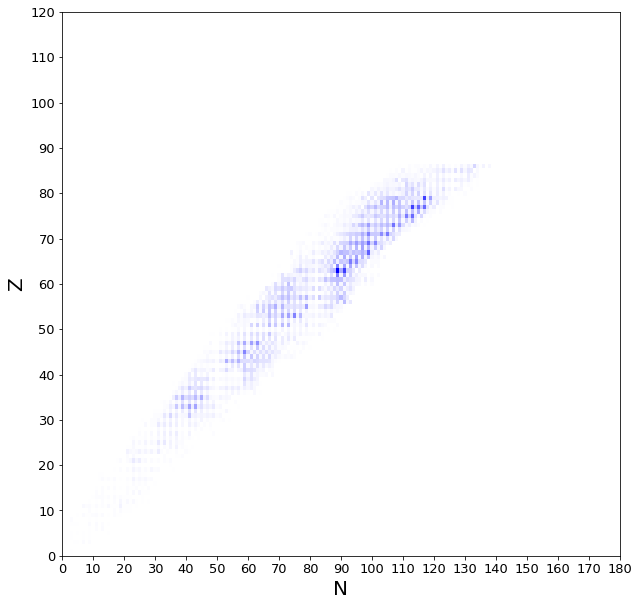

In [118]:
fig = plt.figure(figsize=(10,10))
for i in range(len(LevelDensity)):
    vertices = [(LevelDensity.iloc[i]["N"]-0.5, LevelDensity.iloc[i]["Z"] + 0.5), (LevelDensity.iloc[i]["N"]+0.5, LevelDensity.iloc[i]["Z"] + 0.5),(LevelDensity.iloc[i]["N"]+0.5,  LevelDensity.iloc[i]["Z"] - 0.5),(LevelDensity.iloc[i]["N"]-0.5,  LevelDensity.iloc[i]["Z"] - 0.5)]
    x, y = zip(*vertices)
    #plt.plot(x,y)
    plt.fill(x, y, color='blue', alpha=LevelDensity.iloc[i]["dens"]/max(LevelDensity["dens"]), linewidth=0)
    
xlow = 85
xup = 95
ylow = 55
yup = 65
    
plt.xlim(xlow,xup)
plt.ylim(ylow,yup)

plt.xticks(np.arange(0,190,10), fontsize="13")
plt.yticks(np.arange(0,130,10), fontsize="13")

plt.xlabel("N", fontsize="20")
plt.ylabel("Z", fontsize="20")
plt.savefig("DensityOfStates.png", facecolor='white', bbox_inches='tight')
plt.show()

In [120]:
LevelDensity.sort_values(by=['dens'])

,N,Z,dens
0,1,0,0
0,46,47,0
0,45,47,0
0,85,46,0
0,84,46,0
...,...,...,...
0,99,67,116
0,113,77,139
0,117,79,139
0,91,63,141
